In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from pandas import json_normalize

# дтп

- `id`: уникальный идентификатор ДТП (в файле дубликатов нет)
- `datetime`: дата и время ДТП (строка, обычно в формате `YYYY-MM-DD HH:MM:SS`)
- `category`: тип ДТП  
  Примеры: `Столкновение`, `Наезд на пешехода`, `Наезд на препятствие`
- `severity`: тяжесть последствий  
  Значения: `Легкий`, `Тяжёлый`, `С погибшими`
- `injured_count`: число раненых (целое число, 0 и выше)
- `dead_count`: число погибших (целое число, 0 и выше)
- `participants_count`: количество участников ДТП  
  В датасете: min 1, median 2, mean ~2.406, max 26
- `light`: условия освещения  
  Примеры: `Светлое время суток`, `В темное время суток, освещение включено`, `Сумерки`
- `region`: территориальная привязка (район/локация), 147 уникальных значений
- `parent_region`: регион верхнего уровня, всегда `Москва`
- `address`: адрес (строка), пропуски 7 831 (около 8.54%)
- `scheme`: код схемы (строка/код), пропуски 2 309 (около 2.52%)

### Многозначные поля (списки строк)
Эти поля содержат список значений (в GeoPandas это обычно `list[str]`)
- `tags`: теги набора  
  Обычно 1 элемент: `Дорожно-транспортные происшествия`
- `nearby`: объекты рядом с местом ДТП  
  Примеры: `Многоквартирные жилые дома`, `Тротуар, пешеходная дорожка`
- `weather`: погодные условия (в рамках текущей задачи можно игнорировать)
- `road_conditions`: состояние покрытия  
  Примеры: `Сухое`, `Мокрое`
- `participant_categories`: категории участников, отмеченные в карточке ДТП  
  Примеры: `Все участники`, `Мотоциклисты`

### Вложенные структуры (списки словарей)
- `vehicles`: список транспортных средств в ДТП  
  Тип: `list[dict]`  
  Структура одного ТС обычно включает:
  - `year`: год выпуска (может быть пустым)
  - `brand`: марка (например `MAZDA`)
  - `model`: модель (например `Mazda 3`)
  - `color`: цвет
  - `category`: категория ТС (например `Мотоциклы` или класс авто)
  - `participants`: список участников внутри ТС (`list[dict]`), обычно водитель и пассажиры  
    Поля участника внутри ТС часто такие:
    - `role`: роль (`Водитель`, `Пассажир`)
    - `gender`: пол
    - `violations`: список нарушений (`list[str]`)
    - `health_status`: статус здоровья (не пострадал, раненый и тд)
    - `years_of_driving_experience`: стаж вождения (может быть пустым)

- `participants`: список участников на уровне ДТП (не привязанных к конкретной машине)  
  Тип: `list[dict]`  
  Частый кейс: пешеходы  
  Типичные поля:
  - `role`: например `Пешеход`
  - `gender`
  - `violations`: список нарушений
  - `health_status`

`vehicles` и `participants` можно анализировать через промежуточные таблицы типа `vehicles_df`: explode по `vehicles` (1 строка = 1 ТС) или explode по `vehicles.participants` и/или `participants`


In [22]:
gdf = gpd.read_file("/Users/pavelbobrinskiy/Downloads/DIPLOMA_with_PAUL/data/moskva.geojson")
print("rows:", len(gdf))
print("columns:", list(gdf.columns))
print("geom types:\n", gdf.geom_type.value_counts(dropna=False))

miss = (gdf.isna().mean().sort_values(ascending=False) * 100).round(2)
print("\nMissing % (top 15):")
print(miss.head(15))


rows: 91749
columns: ['id', 'tags', 'light', 'point', 'nearby', 'region', 'scheme', 'address', 'weather', 'category', 'datetime', 'severity', 'vehicles', 'dead_count', 'participants', 'injured_count', 'parent_region', 'road_conditions', 'participants_count', 'participant_categories', 'geometry']
geom types:
 Point    91666
None        83
Name: count, dtype: int64

Missing % (top 15):
address                   8.54
scheme                    2.52
geometry                  0.09
vehicles                  0.00
participant_categories    0.00
participants_count        0.00
road_conditions           0.00
parent_region             0.00
injured_count             0.00
participants              0.00
dead_count                0.00
id                        0.00
severity                  0.00
tags                      0.00
category                  0.00
dtype: float64


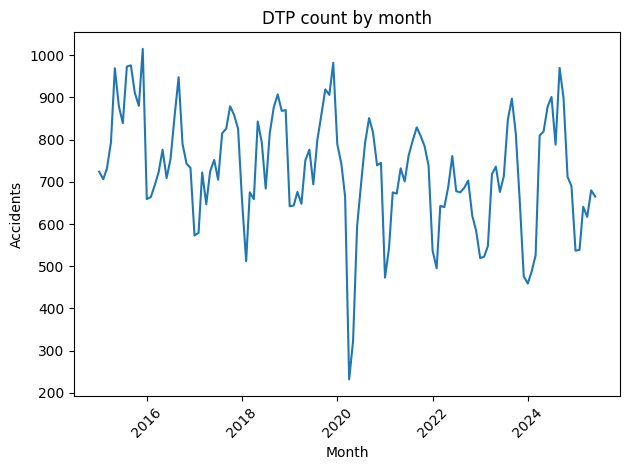

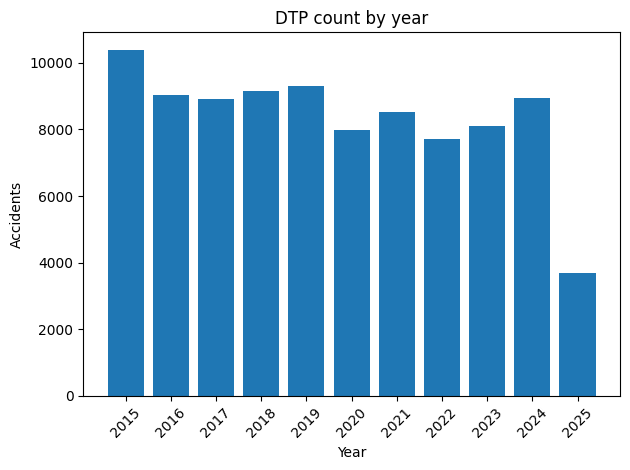

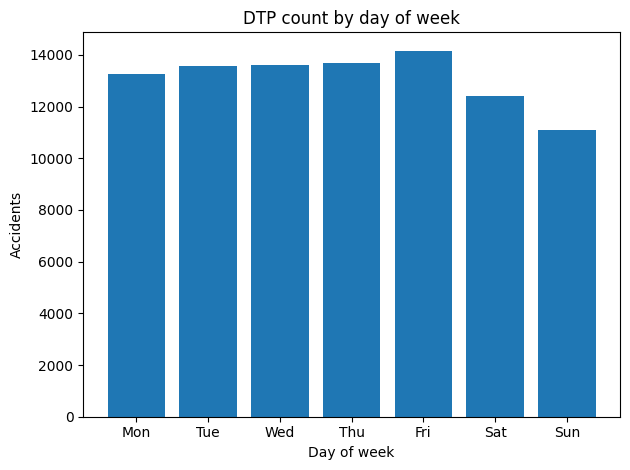

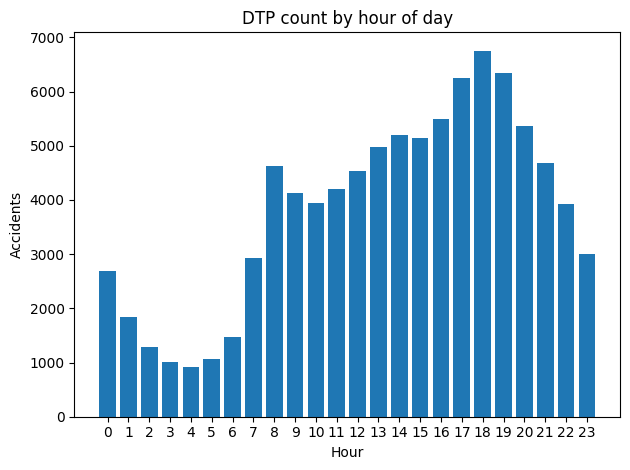

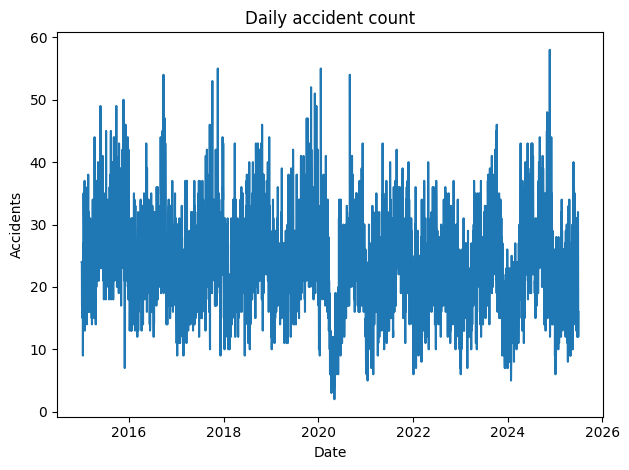

In [17]:
dt = pd.to_datetime(gdf["datetime"], errors="coerce")
assert dt.isna().sum() == 0

# 1) По месяцам (главная картинка для будущего join с воздухом)
monthly = dt.dt.to_period("M").value_counts().sort_index()
plt.figure()
plt.plot(monthly.index.to_timestamp(), monthly.values)
plt.title("DTP count by month")
plt.xlabel("Month")
plt.ylabel("Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) По годам
yearly = dt.dt.year.value_counts().sort_index()
plt.figure()
plt.bar(yearly.index.astype(str), yearly.values)
plt.title("DTP count by year")
plt.xlabel("Year")
plt.ylabel("Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) По дням недели
dow = dt.dt.dayofweek.value_counts().sort_index()
dow_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.figure()
plt.bar([dow_names[i] for i in dow.index], dow.values)
plt.title("DTP count by day of week")
plt.xlabel("Day of week")
plt.ylabel("Accidents")
plt.tight_layout()
plt.show()

# 4) По часам
hourly = dt.dt.hour.value_counts().sort_index()
plt.figure()
plt.bar(hourly.index.astype(str), hourly.values)
plt.title("DTP count by hour of day")
plt.xlabel("Hour")
plt.ylabel("Accidents")
plt.tight_layout()
plt.show()

# 5) Ежедневные данные (это будет основной уровень для модели с воздухом)
daily = dt.dt.floor("D").value_counts().sort_index()
plt.figure()
plt.plot(daily.index, daily.values)
plt.title("Daily accident count")
plt.xlabel("Date")
plt.ylabel("Accidents")
plt.tight_layout()
plt.show()


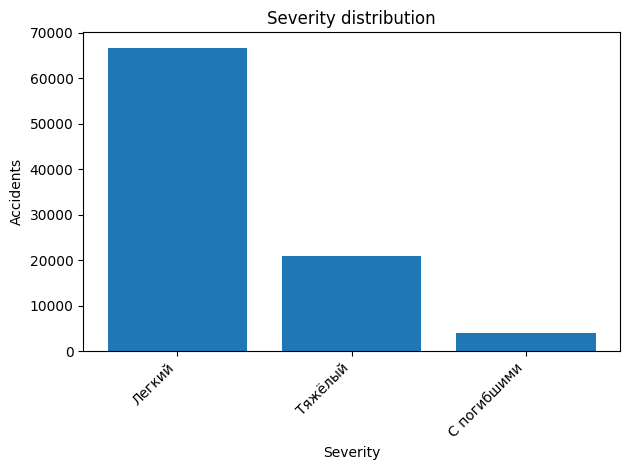

/var/folders/y1/g6x7rg5n1j3cmtcflhwv_hhr0000gn/T/ipykernel_30841/3775106113.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


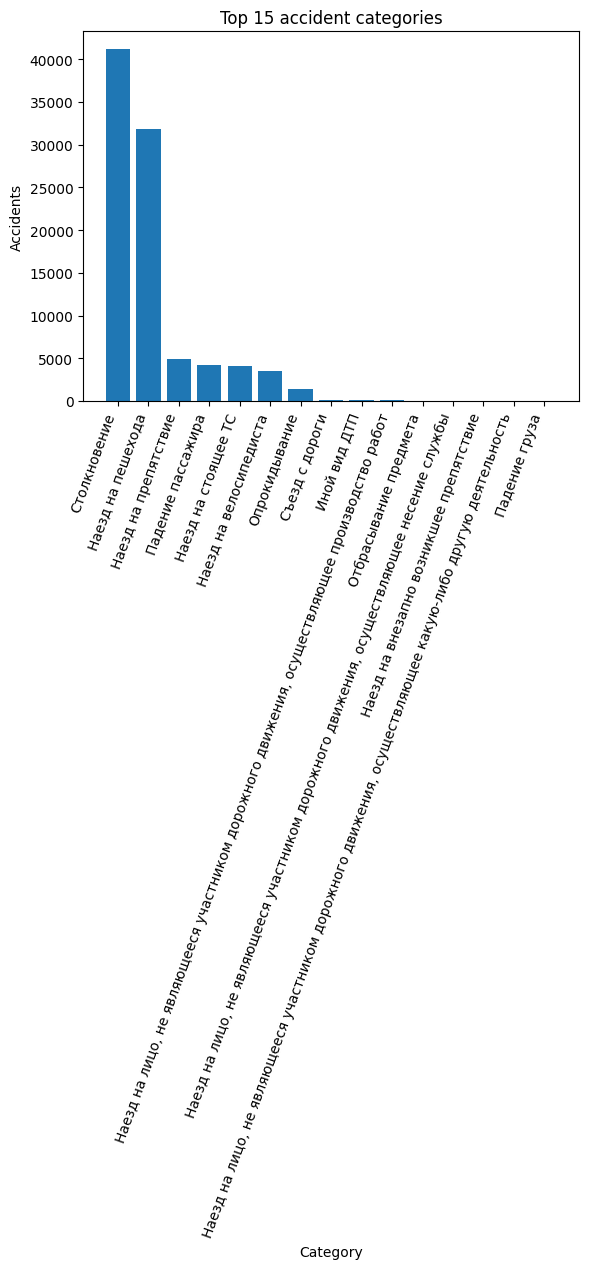

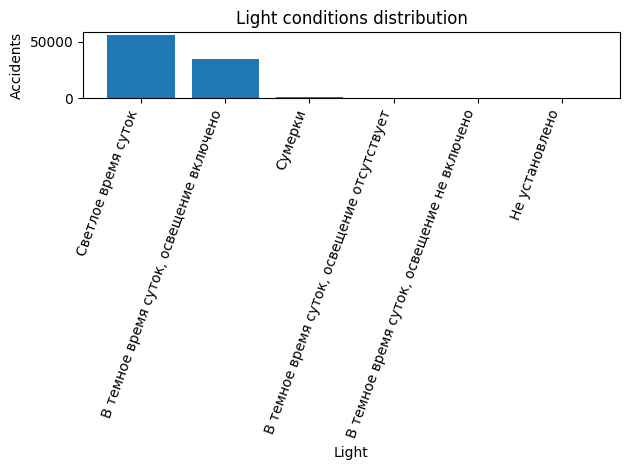

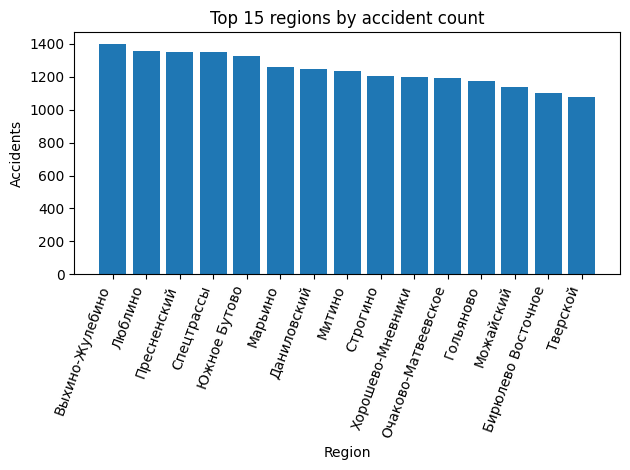

In [18]:
# Severity distribution
sev = gdf["severity"].astype("string").value_counts()
plt.figure()
plt.bar(sev.index.astype(str), sev.values)
plt.title("Severity distribution")
plt.xlabel("Severity")
plt.ylabel("Accidents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Category top 15
cat = gdf["category"].astype("string").value_counts().head(15)
plt.figure()
plt.bar(cat.index.astype(str), cat.values)
plt.title("Top 15 accident categories")
plt.xlabel("Category")
plt.ylabel("Accidents")
plt.xticks(rotation=70, ha="right")
plt.tight_layout()
plt.show()

# Light conditions
light = gdf["light"].astype("string").value_counts()
plt.figure()
plt.bar(light.index.astype(str), light.values)
plt.title("Light conditions distribution")
plt.xlabel("Light")
plt.ylabel("Accidents")
plt.xticks(rotation=70, ha="right")
plt.tight_layout()
plt.show()

# Top regions
reg = gdf["region"].astype("string").value_counts().head(15)
plt.figure()
plt.bar(reg.index.astype(str), reg.values)
plt.title("Top 15 regions by accident count")
plt.xlabel("Region")
plt.ylabel("Accidents")
plt.xticks(rotation=70, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
dt = pd.to_datetime(gdf["datetime"], errors="coerce")
if dt.isna().any():
    raise ValueError("Есть строки с некорректным datetime, проверь gdf['datetime']")

# координаты (не пишем в gdf)
lon = gdf.geometry.x.to_numpy()
lat = gdf.geometry.y.to_numpy()

# диагностическая эвристика: иногда lon/lat перепутаны местами
swap = (lon >= 54) & (lon <= 57) & (lat >= 35) & (lat <= 41)
lon2 = lon.copy()
lat2 = lat.copy()
lon2[swap], lat2[swap] = lat2[swap], lon2[swap]

# participants_count статистики (для контроля качества)
participants_count = pd.to_numeric(gdf["participants_count"], errors="coerce")

# -----------------------------
# 1) accidents_df: компактная таблица по ДТП
# -----------------------------
def as_list(x):
    # vehicles/participants иногда могут приехать строкой, приводим к list
    if isinstance(x, list):
        return x
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, str):
        s = x.strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                v = json.loads(s)
                return v if isinstance(v, list) else []
            except Exception:
                return []
    return []

vehicles_list = gdf["vehicles"].apply(as_list)

accidents_df = pd.DataFrame({
    "id": gdf["id"],
    "datetime": dt,
    "date": dt.dt.floor("D"),
    "month": dt.dt.to_period("M").dt.to_timestamp(),
    "category": gdf["category"].astype("string"),
    "severity": gdf["severity"].astype("string"),
    "injured_count": pd.to_numeric(gdf["injured_count"], errors="coerce"),
    "dead_count": pd.to_numeric(gdf["dead_count"], errors="coerce"),
    "participants_count": participants_count,
    "light": gdf["light"].astype("string"),
    "region": gdf["region"].astype("string"),
    "parent_region": gdf["parent_region"].astype("string"),
    "address": gdf["address"].astype("string"),
    "scheme": gdf["scheme"].astype("string"),
    "lon": lon2,
    "lat": lat2,
    "vehicles_count": vehicles_list.apply(len),
})

# флаги последствий
accidents_df["severe"] = (accidents_df["severity"] != "Легкий").astype(int)
accidents_df["fatal"] = (accidents_df["dead_count"].fillna(0) > 0).astype(int)

daily_df = accidents_df.groupby("date").agg(
    accidents=("id", "count"),
    avg_vehicles=("vehicles_count", "mean"),
    severe_share=("severe", "mean"),
    fatal_share=("fatal", "mean"),
    mean_injured=("injured_count", "mean"),
).reset_index().sort_values("date")

display(accidents_df.head(10))
display(daily_df.head(10))

,id,datetime,date,month,category,severity,injured_count,dead_count,participants_count,light,region,parent_region,address,scheme,lon,lat,vehicles_count,severe,fatal
0,749814,2023-06-14 17:55:00,2023-06-14,2023-06-01,Столкновение,Легкий,1,0,2,Светлое время суток,Южное Тушино,Москва,<NA>,200,37.431085,55.843850,2,0,0
1,751071,2015-04-14 18:00:00,2015-04-14,2015-04-01,Столкновение,Легкий,1,0,3,Светлое время суток,Южное Тушино,Москва,"г Москва, ул Свободы, 30",300,37.455556,55.840556,2,0,0
2,751217,2015-02-25 16:34:00,2015-02-25,2015-02-01,Столкновение,Тяжёлый,1,0,2,Светлое время суток,Южное Тушино,Москва,"г Москва, ул Сходненская, 36",500,37.439167,55.843333,2,1,0
3,751227,2015-02-18 09:45:00,2015-02-18,2015-02-01,Наезд на пешехода,Легкий,1,0,2,Светлое время суток,Южное Тушино,Москва,"г Москва, проезд Походный, 9",820,37.416667,55.838056,1,0,0
4,751233,2015-02-17 18:40:00,2015-02-17,2015-02-01,Столкновение,Легкий,1,0,2,Светлое время суток,Южное Тушино,Москва,"г Москва, ул Свободы, 47",300,37.453889,55.846944,2,0,0
5,751239,2015-02-17 03:05:00,2015-02-17,2015-02-01,Наезд на стоящее ТС,Легкий,1,0,2,"В темное время суток, освещение включено",Южное Тушино,Москва,"г Москва, ул Свободы, д.40, корп",070,37.455556,55.844444,2,0,0
6,751252,2015-02-11 16:20:00,2015-02-11,2015-02-01,Наезд на пешехода,Тяжёлый,1,0,2,Светлое время суток,Южное Тушино,Москва,"г Москва, б-р Яна Райниса, 41",820,37.411111,55.850278,1,1,0
7,751258,2015-02-09 16:34:00,2015-02-09,2015-02-01,Столкновение,Легкий,1,0,2,Светлое время суток,Южное Тушино,Москва,"г Москва, ул Свободы, 44",500,37.453333,55.847500,2,0,0
8,751281,2015-01-23 18:30:00,2015-01-23,2015-01-01,Наезд на пешехода,Легкий,1,0,2,"В темное время суток, освещение включено",Южное Тушино,Москва,"г Москва, проезд Трикотажный, 1",740,37.402222,55.833056,1,0,0
9,748283,2022-12-26 18:32:00,2022-12-26,2022-12-01,Столкновение,Легкий,1,0,3,"В темное время суток, освещение включено",Южное Тушино,Москва,"г Москва, ул Фабрициуса, 37",300,37.424616,55.844314,2,0,0


,date,accidents,avg_vehicles,severe_share,fatal_share,mean_injured
0,2015-01-01,24,1.583333,0.458333,0.083333,1.125000
1,2015-01-02,24,1.500000,0.375000,0.083333,1.750000
2,2015-01-03,17,1.294118,0.411765,0.058824,1.235294
3,2015-01-04,17,1.529412,0.352941,0.000000,1.117647
4,2015-01-05,17,1.764706,0.294118,0.058824,1.117647
5,2015-01-06,20,1.650000,0.200000,0.050000,1.200000
6,2015-01-07,15,2.333333,0.400000,0.000000,1.133333
7,2015-01-08,21,1.857143,0.428571,0.095238,1.190476
8,2015-01-09,24,1.875000,0.291667,0.083333,1.416667
9,2015-01-10,9,2.333333,0.111111,0.111111,1.111111


,v_bucket,accidents,severe_share,fatal_share,mean_injured
0,0,397,0.254408,0.025189,0.982368
1,1,41633,0.312228,0.060289,1.017774
2,2,40467,0.236563,0.029827,1.205254
3,3,7135,0.251437,0.036861,1.316748
4,4,1590,0.257862,0.042767,1.410692
5,5,369,0.295393,0.070461,1.647696
6,6,96,0.322917,0.072917,2.041667
7,7,41,0.439024,0.146341,1.951220
8,8,13,0.538462,0.000000,1.923077
9,9,4,0.750000,0.750000,2.750000


In [ ]:
# vehicles_df: 1 строка = 1 транспортное средство в ДТП
vehicles_expl = pd.DataFrame({
    "accident_id": gdf["id"],
    "vehicle": gdf["vehicles"].apply(as_list)
}).explode("vehicle")

vehicles_expl = vehicles_expl.dropna(subset=["vehicle"]).reset_index(drop=True)

veh_props = json_normalize(vehicles_expl["vehicle"])
vehicles_df = pd.concat([vehicles_expl.drop(columns=["vehicle"]), veh_props], axis=1)

# небольшая чистка имен
vehicles_df = vehicles_df.rename(columns={"category": "vehicle_category"})
vehicles_df["year"] = pd.to_numeric(vehicles_df.get("year"), errors="coerce")

# размер participants внутри машины, если поле есть
if "participants" in vehicles_df.columns:
    vehicles_df["participants_in_vehicle"] = vehicles_df["participants"].apply(
        lambda x: len(x) if isinstance(x, list) else 0
    )

# топы
top_vehicle_category = vehicles_df["vehicle_category"].astype("string").value_counts().head(20).reset_index()
top_vehicle_category.columns = ["vehicle_category", "count"]

top_brand = vehicles_df["brand"].astype("string").value_counts().head(20).reset_index()
top_brand.columns = ["brand", "count"]

year_counts = vehicles_df["year"].dropna().astype(int).value_counts().sort_index().reset_index()
year_counts.columns = ["year", "vehicles"]

display(vehicles_df.head(10))
display(top_vehicle_category)
display(top_brand)
display(year_counts.tail(15))  # последние годы


,accident_id,year,brand,color,model,vehicle_category,participants,participants_in_vehicle
0,749814,2021.0,Прочие марки ТС,Многоцветный,Прочие марки и модели ТС,Иные ТС,"[{'role': 'Водитель', 'gender': 'Мужской', 'vi...",1
1,749814,2021.0,Прочие марки ТС,Многоцветный,Прочие марки и модели ТС,Иные ТС,"[{'role': 'Водитель', 'gender': 'Женский', 'vi...",1
2,751071,2006.0,MAZDA,Желтый,Mazda 3,"D-класс (средний) до 4,6 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi...",2
3,751071,2011.0,Прочие марки мотоциклов,Красный,Прочие марки мотоциклов,Мотоциклы,"[{'role': 'Водитель', 'gender': 'Мужской', 'vi...",1
4,751217,2012.0,RENAULT,Иные цвета,Logan,"В-класс (малый) до 3,9 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi...",1
5,751217,2011.0,AUDI,Черный,Q7,"Е-класс (высший средний, бизнес-класс) до 4,9 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi...",1
6,751227,2010.0,ЗАЗ,Иные цвета,ЗАЗ Sens,"В-класс (малый) до 3,9 м","[{'role': 'Водитель', 'gender': 'Женский', 'vi...",1
7,751233,2011.0,RENAULT,Белый,Прочие модели Renault,"В-класс (малый) до 3,9 м","[{'role': 'Водитель', 'gender': 'Женский', 'vi...",1
8,751233,2003.0,LEXUS,Иные цвета,RX,"Е-класс (высший средний, бизнес-класс) до 4,9 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi...",1
9,751239,2006.0,TOYOTA,Черный,Camry,"Е-класс (высший средний, бизнес-класс) до 4,9 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi...",1


,vehicle_category,count
0,"В-класс (малый) до 3,9 м",38874
1,"С-класс (малый средний, компактный) до 4,3 м",28304
2,"D-класс (средний) до 4,6 м",14284
3,Прочие легковые автомобили,13633
4,Минивэны и универсалы повышенной вместимости,10479
5,Мотоциклы,6929
6,Фургоны,5584
7,Велосипеды,4106
8,"Е-класс (высший средний, бизнес-класс) до 4,9 м",3498
9,Прочие одноярусные,3379


,brand,count
0,HYUNDAI,13878
1,KIA,13059
2,VOLKSWAGEN,8933
3,ВАЗ,7621
4,MERCEDES,6758
5,FORD,6549
6,TOYOTA,6250
7,Прочие марки ТС,6116
8,SKODA,6098
9,NISSAN,5867


,year,vehicles
50,2011,9533
51,2012,11332
52,2013,11244
53,2014,10239
54,2015,7929
55,2016,8016
56,2017,7988
57,2018,8656
58,2019,7705
59,2020,4808


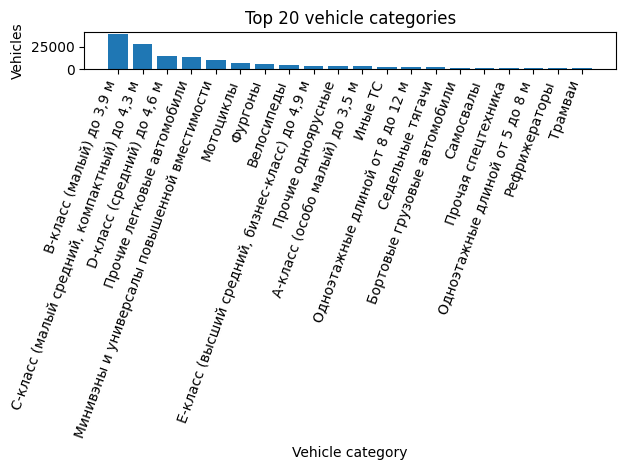

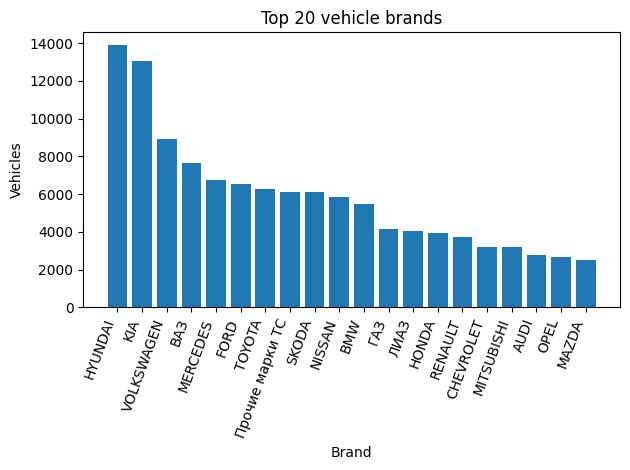

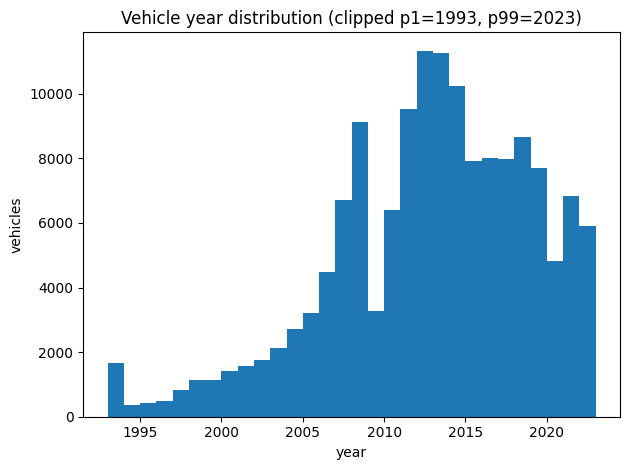

In [ ]:
# Топ категорий ТС
top_vc = vehicles_df["vehicle_category"].astype("string").value_counts().head(20)
plt.figure()
plt.bar(top_vc.index.astype(str), top_vc.values)
plt.title("Top 20 vehicle categories")
plt.xlabel("Vehicle category")
plt.ylabel("Vehicles")
plt.xticks(rotation=70, ha="right")
plt.tight_layout()
plt.show()

# оп марок
top_b = vehicles_df["brand"].astype("string").value_counts().head(20)
plt.figure()
plt.bar(top_b.index.astype(str), top_b.values)
plt.title("Top 20 vehicle brands")
plt.xlabel("Brand")
plt.ylabel("Vehicles")
plt.xticks(rotation=70, ha="right")
plt.tight_layout()
plt.show()

# Год выпуска ТС (если есть)
yrs = vehicles_df["year"].dropna().to_numpy()
if len(yrs):
    y1 = int(np.quantile(yrs, 0.01))
    y99 = int(np.quantile(yrs, 0.99))
    plt.figure()
    plt.hist(np.clip(yrs, y1, y99), bins=30)
    plt.title(f"Vehicle year distribution (clipped p1={y1}, p99={y99})")
    plt.xlabel("year")
    plt.ylabel("vehicles")
    plt.tight_layout()
    plt.show()


# состояние воздуха

In [5]:
# https://data.mos.ru/opendata/2453/description
dirty = pd.read_csv('data-2453-2025-12-29.csv', sep = ';')
# dirty[dirty['AdmArea'] == 'Центральный административный округ']
dirty[(dirty['Period'] > '02.2016') & (dirty['AdmArea'] == 'Центральный административный округ')]


,ID,Period,global_id,StationName,SurveillanceZoneCharacteristics,AdmArea,District,Location,Parameter,MonthlyAverage,MonthlyAveragePDKss,Unnamed: 11
422,422,03.2016,272777688,Сухаревская площадь,Вблизи автомагистралей 1,Центральный административный округ,Мещанский район,"Малая Сухаревская площадь, дом 1, строение 1",Сумма углеводородных соединений за вычетом метана,0.28,NaN,NaN
423,423,03.2016,272777689,Сухаревская площадь,Вблизи автомагистралей 1,Центральный административный округ,Мещанский район,"Малая Сухаревская площадь, дом 1, строение 1",Сумма углеводородных соединений,1.61,NaN,NaN
424,424,03.2016,272777690,Сухаревская площадь,Вблизи автомагистралей 1,Центральный административный округ,Мещанский район,"Малая Сухаревская площадь, дом 1, строение 1",Метан,1.33,NaN,NaN
425,425,03.2016,272777691,Сухаревская площадь,Вблизи автомагистралей 1,Центральный административный округ,Мещанский район,"Малая Сухаревская площадь, дом 1, строение 1",Оксид углерода,0.57,0.19,NaN
426,426,03.2016,272777692,Сухаревская площадь,Вблизи автомагистралей 1,Центральный административный округ,Мещанский район,"Малая Сухаревская площадь, дом 1, строение 1",Оксид азота,0.029,0.49,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
36401,1121782,11.2025,2837524394,Хамовники,Вблизи автомагистралей,Центральный административный округ,район Хамовники,"Российская Федерация, город Москва, внутригоро...",Оксид углерода,0.41,0.14,NaN
36402,1121783,11.2025,2837524395,Хамовники,Вблизи автомагистралей,Центральный административный округ,район Хамовники,"Российская Федерация, город Москва, внутригоро...",Сероводород,0.0012,NaN,NaN
36403,1121784,11.2025,2837524396,Хамовники,Вблизи автомагистралей,Центральный административный округ,район Хамовники,"Российская Федерация, город Москва, внутригоро...",Оксид азота,0.045,NaN,NaN
36404,1121785,11.2025,2837524398,Хамовники,Вблизи автомагистралей,Центральный административный округ,район Хамовники,"Российская Федерация, город Москва, внутригоро...",Диоксид азота,0.034,0.34,NaN


https://mosecom.mos.ru/basic/

https://aqicn.org/historical/ru/#:~:text=%D0%9C%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D1%8F%20%D0%B8%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F%20%D0%B1%D0%B0%D0%B7%D0%B0%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%20%D0%BE,%C2%B7%20%D0%95%D0%B6%D0%B5%D0%BD%D0%B5%D0%B4%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9%20%D0%B8%D0%BD%D0%B4%D0%B5%D0%BA%D1%81%20%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0



Тут можно запарсить csv шки

# Погода

https://www.pogodaiklimat.ru/weather.php?id=27612#:~:text=%D0%90%D1%80%D1%85%D0%B8%D0%B2%20%D0%BF%D0%BE%D0%B3%D0%BE%D0%B4%D1%8B%20%D0%B2%20%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B5%20,%D1%81%20%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8F%202011%20%D0%B3%D0%BE%D0%B4%D0%B0%2C

### Временные и идентификационные поля
- `station_id`  
  Идентификатор метеостанции (в текущем файле чаще всего одна станция, но поле оставлено на будущее)

- `dt_utc`  
  Дата и время наблюдения в UTC (строка/время). Это “сырой” временной ключ файла

- `year`, `month`, `day_month`, `hour_utc`  
  Компоненты времени в UTC (год, месяц, день месяца, час). Удобны для быстрых группировок, но для правильного совпадения с ДТП лучше использовать локальное время Москвы


---

### Ветер, видимость, явления, облачность
- `wind_dir`  
  Направление ветра (откуда дует). В твоем “clean” файле хранится в компактном виде: `N, NE, E, SE, S, SW, W, NW`  
  Смысл соответствует описанию: С, СВ, В, ЮВ, Ю, ЮЗ, З, СЗ

- `wind_speed_mps`  
  Скорость ветра, м/с. По смыслу это средняя скорость (в исходном формате pogodaiklimat обычно средняя за 10 минут)

- `visibility`  
  Горизонтальная дальность видимости. В clean-файле это численное значение (как правило в метрах)  
  Интерпретация: при видимости 1–10 км без осадков часто дымка, при 1 км и менее часто туман. В сухую погоду ухудшение может быть из-за дыма/пыли/мглы

- `phenomena`  
  Атмосферные явления (строка). По смыслу соответствует “Явления” из описания: что наблюдалось в срок или в последний час перед сроком  
  В исходной терминологии:
  - фигурные скобки `{...}` означают явления между сроками (за 1–3 часа до срока)
  - квадратные скобки `[...]` могут обозначать град/гололедные отложения с диаметром в мм  
  В clean-файле это поле оставлено текстом, удобно анализировать как категорию (top-N явлений)

- `cloudiness`  
  Облачность (строка). По смыслу: “общая/нижняя облачность” + высота нижней границы, и в квадратных скобках формы облаков  
  Пример форм: `Ci, Cs, Cc, Ac, As, Sc, Ns, Cu, Cb`

---

### Температуры и влажность
- `temp_c`  
  Температура воздуха, °C (T). Измеряется на высоте 2 м над землей

- `dewpoint_c`  
  Температура точки росы, °C (Td). Температура, при которой водяной пар достигает насыщения

- `humidity_pct`  
  Относительная влажность воздуха, % (f). Также относится к измерениям на высоте 2 м

- `te_c`  
  Эффективная температура, °C (Te). “Ощущаемая” температура в тени с учетом влажности и скорости ветра (показатель душности)

- `tes_c`  
  Эффективная температура на солнце, °C (Tes). Учитывает солнечный нагрев; ночью/в пасмурную погоду и при ветре 12 м/с и выше поправка обычно ≈ 0

- `comfort`  
  Служебное поле комфорта/ощущения (в разных выгрузках может быть строкой или кодом). Его смысл зависит от конкретного источника преобразования, поэтому лучше использовать как категорию только после просмотра уникальных значений

---

### Давление
- `pressure_hpa`  
  Давление на уровне метеостанции (Po), единицы: гПа (hPa)

- `pressure_sea_hpa`  
  Давление, приведенное к уровню моря (P), гПа (hPa). Обычно именно его используют для синоптики и стабильных сравнений

---

### Экстремумы температуры
- `tmin_c`  
  Минимальная температура воздуха за период наблюдений, °C (Tmin)

- `tmax_c`  
  Максимальная температура воздуха за период наблюдений, °C (Tmax)

---

### Осадки и снег
- `precip_mm`  
  Количество осадков за период, мм (R). Период зависит от частоты наблюдений в данных

- `precip_24h_mm`  
  Осадки за 24 часа, мм (R24)

- `snow_cm`  
  Высота снежного покрова, см (S)


/var/folders/y1/g6x7rg5n1j3cmtcflhwv_hhr0000gn/T/ipykernel_30841/2920607068.py:1: DtypeWarning: Columns (13,14,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/pavelbobrinskiy/Downloads/DIPLOMA_with_PAUL/data/pogodaiklimat_archive_filled_fixed_clean.csv')


,rows,dt_utc_min,dt_utc_max,dt_msk_min,dt_msk_max
0,34767,2015-01-01 00:00:00+00:00,2026-01-31 21:00:00+00:00,2015-01-01 03:00:00+03:00,2026-02-01 00:00:00+03:00


,column,bounds,non_null,bad_count,bad_%_of_non_null
1,dewpoint_c,"[-80, 40]",34766,9957,28.640
5,pressure_sea_hpa,"[850, 1100]",27308,4058,14.860
2,humidity_pct,"[0, 100]",34748,2851,8.205
3,wind_speed_mps,"[0, 50]",34560,985,2.850
13,tes_c,"[-80, 80]",23271,24,0.103
12,te_c,"[-80, 60]",34741,20,0.058
0,temp_c,"[-60, 60]",34766,6,0.017
6,pressure_hpa,"[850, 1100]",34727,4,0.012
4,visibility,"[0, 50000]",25195,2,0.008
10,tmin_c,"[-60, 60]",8493,1,0.012


,date_msk,obs,temp_mean,temp_min,temp_max,humidity_mean,pressure_mean,wind_mean,visibility_mean,precip_sum,snow_mean
0,2015-01-01,7,-2.0000,-5.5,0.6,96.714286,990.314286,1.142857,4000.000000,0.0,NaN
1,2015-01-02,8,1.1750,0.7,1.9,97.500000,982.362500,1.250000,4000.000000,0.0,NaN
2,2015-01-03,8,1.9250,1.2,2.4,91.375000,967.175000,1.750000,4000.000000,13.0,NaN
3,2015-01-04,8,0.0750,-1.0,1.0,94.166667,963.466667,1.714286,4000.000000,11.0,NaN
4,2015-01-05,8,-8.1750,-15.3,-1.2,81.625000,976.662500,3.000000,1340.000000,15.0,NaN
5,2015-01-06,8,-20.4500,-22.5,-17.4,74.750000,992.250000,2.800000,10.000000,16.0,NaN
6,2015-01-07,8,-20.2875,-22.8,-16.8,89.000000,1012.450000,1.250000,10.000000,0.0,NaN
7,2015-01-08,8,-14.0000,-17.3,-9.3,79.333333,1004.450000,1.000000,10.000000,0.0,NaN
8,2015-01-09,8,-8.3875,-10.2,-6.8,88.000000,981.857143,1.375000,3333.333333,17.0,NaN
9,2015-01-10,8,-5.1750,-9.6,-2.3,92.500000,971.000000,0.625000,4000.000000,27.0,NaN


,month_start,obs,temp_mean,humidity_mean,pressure_mean,wind_mean,visibility_mean,precip_sum,snow_mean
0,2015-01-01,249,-5.157430,87.554974,989.799462,1.361345,2122.580645,538.0,NaN
1,2015-02-01,660,-2.233333,80.370821,997.099844,1.460829,1693.859649,78.0,37.642857
2,2015-03-01,743,-4.378869,33.343545,998.325157,1.394922,634.583333,183.0,NaN
3,2015-04-01,719,6.031711,66.399441,989.235335,1.543192,739.610092,85.8,2.428571
4,2015-05-01,743,6.941992,30.973046,989.691195,1.046133,710.727651,0.0,NaN
5,2015-06-01,720,17.947222,62.645833,995.890390,1.099024,564.939516,187.0,NaN
6,2015-07-01,250,13.219600,46.364000,988.556566,0.954545,701.269841,0.0,NaN
7,2015-08-01,248,10.989919,36.806452,1000.607813,1.056452,529.408284,0.0,NaN
8,2015-09-01,240,13.821667,76.475000,1001.137238,0.629167,1070.419580,174.0,NaN
9,2015-10-01,248,1.100806,43.193694,1000.035577,1.025751,764.864865,1.0,NaN


,wind_dir,count
0,штиль,8963
1,З,4625
2,Ю,4328
3,С,3992
4,СЗ,3926
5,ЮВ,3312
6,ЮЗ,2094
7,В,1920
8,СВ,1564
9,<NA>,18


,phenomena,count
0,<NA>,8862
1,дымка,3918
2,ясно,2408
3,слаб. снег,1594
4,10/10 600 м [Sc],968
5,слаб. ливневой дождь,799
6,в посл. час ливневой дождь,710
7,слаб. дождь,665
8,{ливн. осадки},581
9,{ливн. дождь},532


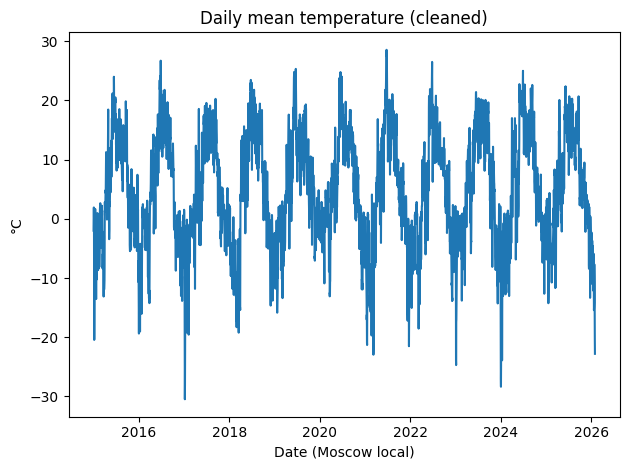

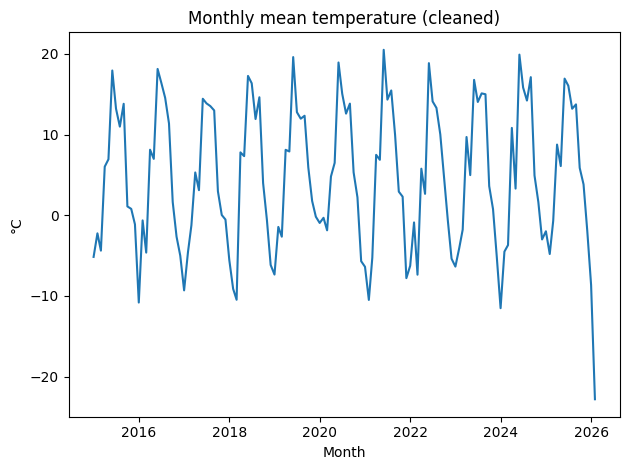

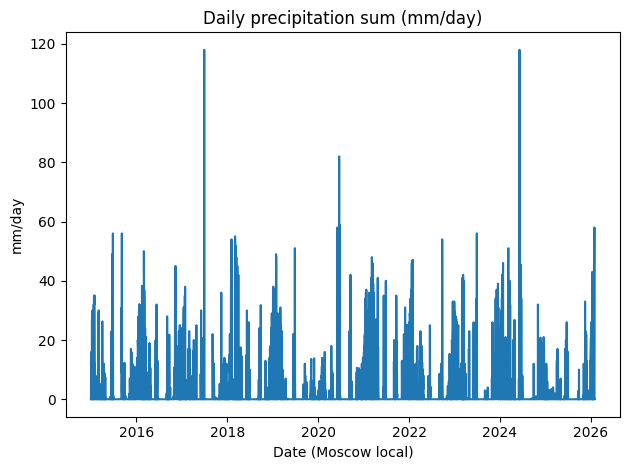

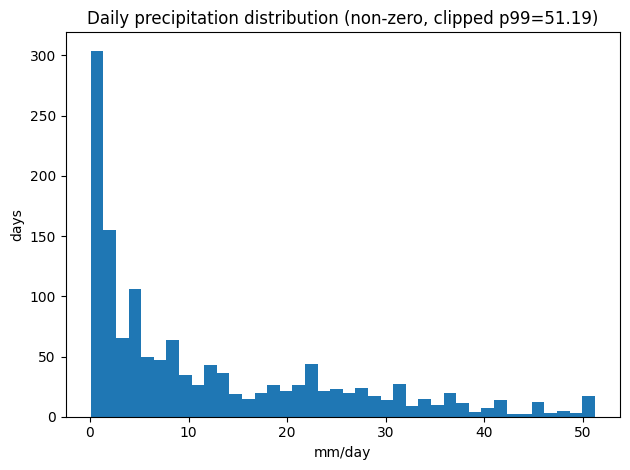

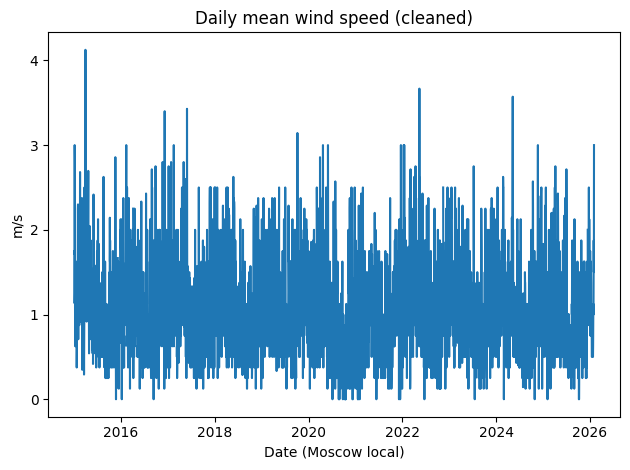

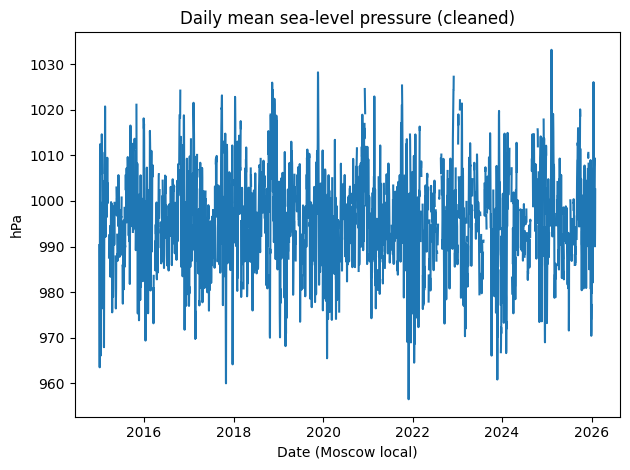

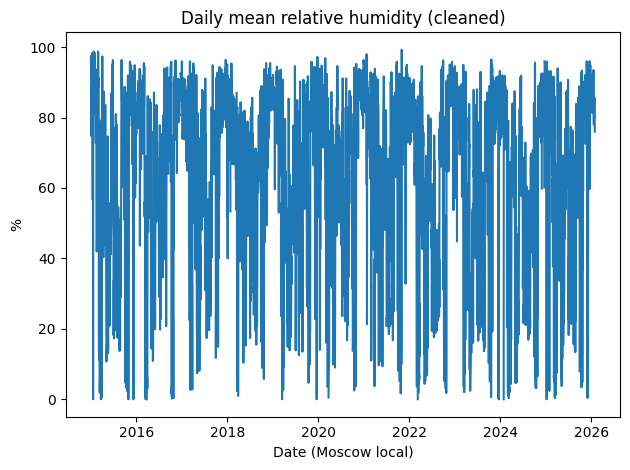

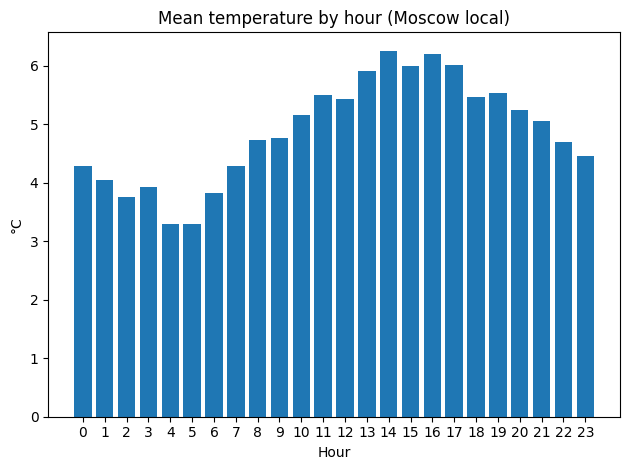

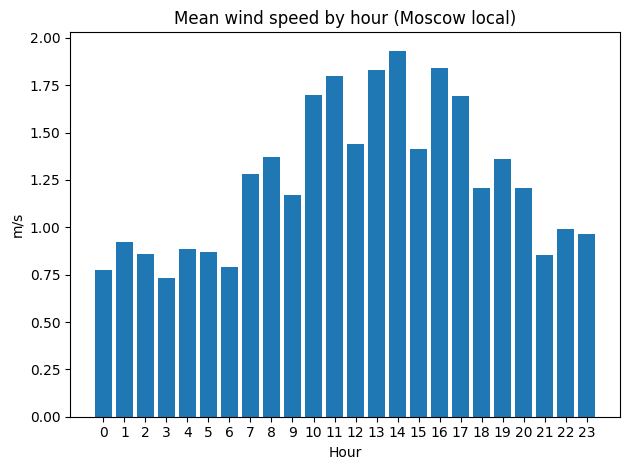

In [ ]:
df = pd.read_csv('/Users/pavelbobrinskiy/Downloads/DIPLOMA_with_PAUL/data/pogodaiklimat_archive_filled_fixed_clean.csv')
df = df[df['dt_utc'] >= '2015-01-01']

df["dt_utc"] = pd.to_datetime(df["dt_utc"], errors="coerce", utc=True)
df["dt_msk"] = df["dt_utc"].dt.tz_convert("Europe/Moscow")
df["date_msk"] = df["dt_msk"].dt.floor("D").dt.tz_localize(None)
df["hour_msk"] = df["dt_msk"].dt.hour

# --- приведение чисел (на случай если где-то остались строки/мусор) ---
numeric_cols = [
    "wind_speed_mps","visibility","temp_c","dewpoint_c","humidity_pct","te_c","tes_c",
    "pressure_hpa","pressure_sea_hpa","tmin_c","tmax_c","precip_mm","precip_24h_mm","snow_cm",
    "year","month","hour_utc","day_month"
]
for c in numeric_cols:
    if c in df.columns:
        s = df[c]
        if s.dtype == "object":
            s = s.astype(str).str.replace(",", ".", regex=False)
            s = s.str.replace(r"[^0-9.\-]+", "", regex=True)
        df[c] = pd.to_numeric(s, errors="coerce")

# --- QC: жесткие sanity bounds, чтобы графики/агрегации не ломались ---
rules = {
    "temp_c": (-60, 60),
    "dewpoint_c": (-80, 40),
    "humidity_pct": (0, 100),
    "wind_speed_mps": (0, 50),
    "visibility": (0, 50000),          # предполагаем метры, очень широкая вилка
    "pressure_sea_hpa": (850, 1100),
    "pressure_hpa": (850, 1100),
    "precip_mm": (0, 300),
    "precip_24h_mm": (0, 300),
    "snow_cm": (0, 200),
    "tmin_c": (-60, 60),
    "tmax_c": (-60, 60),
    "te_c": (-80, 60),
    "tes_c": (-80, 80),
}

df_clean = df.copy()
qc_rows = []
for col, (lo, hi) in rules.items():
    if col not in df_clean.columns:
        continue
    x = df_clean[col]
    bad = x.notna() & ((x < lo) | (x > hi))
    qc_rows.append({
        "column": col,
        "bounds": f"[{lo}, {hi}]",
        "non_null": int(x.notna().sum()),
        "bad_count": int(bad.sum()),
        "bad_%_of_non_null": round(100 * bad.sum() / max(1, x.notna().sum()), 3),
    })
    df_clean.loc[bad, col] = np.nan

qc_df = pd.DataFrame(qc_rows).sort_values("bad_count", ascending=False)

# --- промежуточные таблицы: это реально понадобится дальше для merge с ДТП/загрязнением ---
daily_df = df_clean.groupby("date_msk").agg(
    obs=("station_id", "count"),
    temp_mean=("temp_c", "mean"),
    temp_min=("temp_c", "min"),
    temp_max=("temp_c", "max"),
    humidity_mean=("humidity_pct", "mean"),
    pressure_mean=("pressure_sea_hpa", "mean"),
    wind_mean=("wind_speed_mps", "mean"),
    visibility_mean=("visibility", "mean"),
    precip_sum=("precip_mm", "sum"),
    snow_mean=("snow_cm", "mean"),
).reset_index().sort_values("date_msk")

monthly_df = df_clean.assign(month_start=df_clean["date_msk"].dt.to_period("M").dt.to_timestamp()).groupby("month_start").agg(
    obs=("station_id", "count"),
    temp_mean=("temp_c", "mean"),
    humidity_mean=("humidity_pct", "mean"),
    pressure_mean=("pressure_sea_hpa", "mean"),
    wind_mean=("wind_speed_mps", "mean"),
    visibility_mean=("visibility", "mean"),
    precip_sum=("precip_mm", "sum"),
    snow_mean=("snow_cm", "mean"),
).reset_index().sort_values("month_start")

wind_dir_df = df_clean["wind_dir"].astype("string").value_counts(dropna=False).reset_index()
wind_dir_df.columns = ["wind_dir", "count"]

phen_df = df_clean["phenomena"].astype("string").value_counts(dropna=False).head(25).reset_index()
phen_df.columns = ["phenomena", "count"]

# --- вывод таблиц (можешь убрать display, если не нужно) ---
display(pd.DataFrame({
    "rows":[len(df)],
    "dt_utc_min":[str(df["dt_utc"].min())],
    "dt_utc_max":[str(df["dt_utc"].max())],
    "dt_msk_min":[str(df["dt_msk"].min())],
    "dt_msk_max":[str(df["dt_msk"].max())],
}))
display(qc_df)
display(daily_df.head(10))
display(monthly_df.head(12))
display(wind_dir_df)
display(phen_df)

# --- Графики (по очищенным значениям) ---

plt.figure()
plt.plot(daily_df["date_msk"], daily_df["temp_mean"])
plt.title("Daily mean temperature (cleaned)")
plt.xlabel("Date (Moscow local)")
plt.ylabel("°C")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(monthly_df["month_start"], monthly_df["temp_mean"])
plt.title("Monthly mean temperature (cleaned)")
plt.xlabel("Month")
plt.ylabel("°C")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(daily_df["date_msk"], daily_df["precip_sum"])
plt.title("Daily precipitation sum (mm/day)")
plt.xlabel("Date (Moscow local)")
plt.ylabel("mm/day")
plt.tight_layout()
plt.show()

x = daily_df["precip_sum"].dropna()
x = x[x > 0]
if len(x):
    clip = float(np.quantile(x, 0.99))
    plt.figure()
    plt.hist(np.clip(x, 0, clip), bins=40)
    plt.title(f"Daily precipitation distribution (non-zero, clipped p99={clip:.2f})")
    plt.xlabel("mm/day")
    plt.ylabel("days")
    plt.tight_layout()
    plt.show()

plt.figure()
plt.plot(daily_df["date_msk"], daily_df["wind_mean"])
plt.title("Daily mean wind speed (cleaned)")
plt.xlabel("Date (Moscow local)")
plt.ylabel("m/s")
plt.tight_layout()
plt.show()

order = ["N","NE","E","SE","S","SW","W","NW"]
counts = df_clean["wind_dir"].astype("string").value_counts()
xs = [d for d in order if d in counts.index]
ys = [int(counts[d]) for d in xs]
if xs:
    plt.figure()
    plt.bar(xs, ys)
    plt.title("Wind direction frequency")
    plt.xlabel("Direction")
    plt.ylabel("observations")
    plt.tight_layout()
    plt.show()

plt.figure()
plt.plot(daily_df["date_msk"], daily_df["pressure_mean"])
plt.title("Daily mean sea-level pressure (cleaned)")
plt.xlabel("Date (Moscow local)")
plt.ylabel("hPa")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(daily_df["date_msk"], daily_df["humidity_mean"])
plt.title("Daily mean relative humidity (cleaned)")
plt.xlabel("Date (Moscow local)")
plt.ylabel("%")
plt.tight_layout()
plt.show()

hourly_temp = df_clean.groupby("hour_msk")["temp_c"].mean().reset_index()
plt.figure()
plt.bar(hourly_temp["hour_msk"].astype(int).astype(str), hourly_temp["temp_c"])
plt.title("Mean temperature by hour (Moscow local)")
plt.xlabel("Hour")
plt.ylabel("°C")
plt.tight_layout()
plt.show()

hourly_wind = df_clean.groupby("hour_msk")["wind_speed_mps"].mean().reset_index()
plt.figure()
plt.bar(hourly_wind["hour_msk"].astype(int).astype(str), hourly_wind["wind_speed_mps"])
plt.title("Mean wind speed by hour (Moscow local)")
plt.xlabel("Hour")
plt.ylabel("m/s")
plt.tight_layout()
plt.show()

